# Dithering Pattern Generator
## 1. Imports and Setup

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import gdspy
from numba import njit
from scipy import sparse

## 2. Parameters and Core Functions

In [ ]:
# =============================================================================
# Basic Parameters
# =============================================================================
R0 = 1.43               # mm
delta_r = 0.42          # mm
pixel_size_um = 15.0    # microns (use 1.6 for production)
plate_size_inch = 1     # inch
INCH_TO_MM = 25.4

# =============================================================================
# Fabrication Layout Parameters
# =============================================================================
# Substrate: 5" total, but usable area is 4.97" (0.015" cut from each edge)
# Streets: 12 mil transparent gaps between masks for computer-vision cutting
# Inner 3x3 masks: Full 1" x 1" size
# Outer ring masks: Reduced to fit 4.97" constraint

STREET_WIDTH_MIL = 12              # Street width in mils (0.012")
FINAL_SIZE_INCH = 4.97             # Final pattern size in inches
INNER_MASK_SIZE_INCH = 1.0         # Inner masks stay full size
NUM_ROWS = 5
NUM_COLS = 5

# Outer mask marker size (to distinguish outer from inner masks)
OUTER_MARKER_SIZE_MM = 0.5         # 0.5mm x 0.5mm black square

# Calculate outer mask size to fit constraint:
# 4.97" = 2*outer + 3*inner + 4*street
# 4.97 = 2*outer + 3*1.0 + 4*0.012
# outer = (4.97 - 3.0 - 0.048) / 2 = 0.961"
OUTER_MASK_SIZE_INCH = (FINAL_SIZE_INCH - 3 * INNER_MASK_SIZE_INCH - 4 * STREET_WIDTH_MIL / 1000) / 2
OUTER_MASK_REDUCTION_MIL = (INNER_MASK_SIZE_INCH - OUTER_MASK_SIZE_INCH) * 1000  # ~39 mil

# Unit conversions
MIL_TO_UM = 25.4
INCH_TO_UM = 25400

plate_size_mm = plate_size_inch * INCH_TO_MM
N = int((plate_size_mm * 1e3)/pixel_size_um)    # number of pixels

# Convert fabrication params to pixels
street_width_um = STREET_WIDTH_MIL * MIL_TO_UM
outer_reduction_um = OUTER_MASK_REDUCTION_MIL * MIL_TO_UM
street_width_px = int(round(street_width_um / pixel_size_um))
outer_reduction_px = int(round(outer_reduction_um / pixel_size_um))
outer_marker_px = int(round(OUTER_MARKER_SIZE_MM * 1000 / pixel_size_um))

print(f"=== Fabrication Layout ===")
print(f"Final pattern size: {FINAL_SIZE_INCH}\" x {FINAL_SIZE_INCH}\"")
print(f"Inner mask size: {INNER_MASK_SIZE_INCH}\" ({N} pixels)")
print(f"Outer mask size: {OUTER_MASK_SIZE_INCH:.3f}\" ({N - outer_reduction_px} pixels)")
print(f"Street width: {STREET_WIDTH_MIL} mil ({street_width_px} pixels)")
print(f"Outer mask reduction: {OUTER_MASK_REDUCTION_MIL:.1f} mil ({outer_reduction_px} pixels)")
print(f"Outer marker size: {OUTER_MARKER_SIZE_MM}mm ({outer_marker_px} pixels)")

# =============================================================================
# Core Functions
# =============================================================================

def transmission_function(r, R0, delta_r):
    r = np.asarray(r)
    T = np.zeros_like(r, dtype=float)

    # Inner cosine ramp up
    mask = (r > R0) & (r <= R0 + delta_r)
    freq = np.pi / delta_r
    T[mask] = (1 - np.cos(freq * (r[mask] - R0))) / 2

    # Fully open region
    mask = (r > R0 + delta_r) 
    T[mask] = 1.0
    return T

def radial_function_to_image(T_r, R0, delta_r, N, extent):
    """
    T_r    : callable, transmission function T(r) in [0,1]
    N      : number of pixels per dimension (NxN)
    extent : physical half-size of mask (mask spans [-extent, extent])
    """
    x = np.linspace(-extent, extent, N, endpoint=False)
    X, Y = np.meshgrid(x, x)
    R = np.sqrt(X**2 + Y**2)

    image = T_r(R, R0, delta_r).astype(np.float32)
    return np.clip(image, 0.0, 1.0)

@njit
def floyd_steinberg_dither_fast(image):
    """Numba-accelerated Floyd-Steinberg dithering."""
    img = image.copy()
    h, w = img.shape

    for y in range(h):
        for x in range(w):
            old = img[y, x]
            new = 1.0 if old >= 0.5 else 0.0
            img[y, x] = new
            error = old - new

            if x + 1 < w:
                img[y, x + 1] += error * 0.4375  # 7/16

            if y + 1 < h:
                if x > 0:
                    img[y + 1, x - 1] += error * 0.1875  # 3/16
                img[y + 1, x] += error * 0.3125  # 5/16
                if x + 1 < w:
                    img[y + 1, x + 1] += error * 0.0625  # 1/16

    return img.astype(np.uint8)

# =============================================================================
# Packed Binary Storage (8x memory reduction)
# =============================================================================

def pack_binary(matrix):
    """Pack a binary matrix using np.packbits for 8x memory reduction."""
    original_shape = matrix.shape
    flat = matrix.flatten().astype(np.uint8)
    packed = np.packbits(flat)
    return packed, original_shape

def unpack_binary(packed, original_shape):
    """Unpack a packed binary matrix back to original form."""
    total_elements = original_shape[0] * original_shape[1]
    unpacked = np.unpackbits(packed)[:total_elements]
    return unpacked.reshape(original_shape)

# =============================================================================
# Mask Generation
# =============================================================================

def generate_mask(R0, delta_r, pixel_size_um, plate_size_inch, return_packed=False):
    """
    Generate a dithered mask.
    
    Parameters:
        R0, delta_r : mask parameters in mm
        pixel_size_um : pixel size in microns
        plate_size_inch : plate size in inches
        return_packed : if True, return packed binary data (8x compression)
    
    Returns:
        If return_packed: ((packed_data, shape), grayscale)
        Otherwise: (binary_matrix, grayscale)
    """
    plate_size_mm = plate_size_inch * INCH_TO_MM
    N = int((plate_size_mm * 1e3)/pixel_size_um)
    extent = plate_size_mm / 2
    
    grayscale = radial_function_to_image(transmission_function, R0, delta_r, N, extent)
    binary = floyd_steinberg_dither_fast(grayscale)
    
    if return_packed:
        return pack_binary(binary), grayscale
    return binary, grayscale

# =============================================================================
# Tile-Based Pattern Assembly with Streets
# =============================================================================

def assemble_pattern_with_streets(tiles, layout, full_tile_size, street_width_px, 
                                   outer_reduction_px, outer_marker_px=0):
    """
    Assemble a pattern from tiles using a layout template.

    Inner masks (3x3 center) stay full size.
    Outer masks (edge ring) are reduced to fit the 4.97" constraint.
    Outer masks get a black square marker at the upper right corner.

    Parameters:
    -----------
    tiles : dict
        Dictionary mapping tile names to 2D numpy arrays
    layout : list of lists
        2D layout template specifying which tile goes where (row 0 = top)
    full_tile_size : int
        Full tile size in pixels (for inner masks)
    street_width_px : int
        Width of streets in pixels (transparent/white)
    outer_reduction_px : int
        Amount to trim from outer masks (not inner masks)
    outer_marker_px : int
        Size of black square marker at upper right corner of outer masks (default: 0 = no marker)

    Returns:
    --------
    numpy.ndarray
        Assembled pattern with streets between tiles
    """
    num_rows = len(layout)
    num_cols = len(layout[0])

    outer_size = full_tile_size - outer_reduction_px

    # Calculate total dimensions
    total_h = 2 * outer_size + (num_rows - 2) * full_tile_size + (num_rows - 1) * street_width_px
    total_w = 2 * outer_size + (num_cols - 2) * full_tile_size + (num_cols - 1) * street_width_px

    # Initialize with white (1) - streets are transparent
    pattern = np.ones((total_h, total_w), dtype=np.uint8)

    y_offset = 0
    for row_idx in range(num_rows):
        is_outer_row = (row_idx == 0 or row_idx == num_rows - 1)
        curr_h = outer_size if is_outer_row else full_tile_size

        if row_idx == 0:
            src_y_start = outer_reduction_px
            src_y_end = full_tile_size
        elif row_idx == num_rows - 1:
            src_y_start = 0
            src_y_end = outer_size
        else:
            src_y_start = 0
            src_y_end = full_tile_size

        x_offset = 0
        for col_idx in range(num_cols):
            is_outer_col = (col_idx == 0 or col_idx == num_cols - 1)
            curr_w = outer_size if is_outer_col else full_tile_size

            if col_idx == 0:
                src_x_start = outer_reduction_px
                src_x_end = full_tile_size
            elif col_idx == num_cols - 1:
                src_x_start = 0
                src_x_end = outer_size
            else:
                src_x_start = 0
                src_x_end = full_tile_size

            tile_name = layout[row_idx][col_idx]
            tile = tiles[tile_name]
            tile_region = tile[src_y_start:src_y_end, src_x_start:src_x_end]
            pattern[y_offset:y_offset+curr_h, x_offset:x_offset+curr_w] = tile_region

            is_outer_mask = is_outer_row or is_outer_col
            if is_outer_mask and outer_marker_px > 0:
                marker_y_start = y_offset
                marker_y_end = y_offset + outer_marker_px
                marker_x_start = x_offset + curr_w - outer_marker_px
                marker_x_end = x_offset + curr_w
                pattern[marker_y_start:marker_y_end, marker_x_start:marker_x_end] = 0

            x_offset += curr_w
            if col_idx < num_cols - 1:
                x_offset += street_width_px

        y_offset += curr_h
        if row_idx < num_rows - 1:
            y_offset += street_width_px

    return pattern


def add_alignment_crosses_in_streets(pattern, layout, full_tile_size, outer_tile_size,
                                      street_width_px, arm_length_px, thickness_px):
    """
    Add cross markers at the center of street intersections.

    Parameters:
    -----------
    pattern : 2D numpy array
        The pattern with streets already in place
    layout : list of lists
        The layout template (to determine grid size)
    full_tile_size : int
        Full tile size in pixels (inner masks)
    outer_tile_size : int
        Outer tile size in pixels (edge masks)
    street_width_px : int
        Width of streets in pixels
    arm_length_px : int
        Length of cross arms in pixels
    thickness_px : int
        Thickness of cross lines in pixels

    Returns:
    --------
    numpy.ndarray
        Pattern with alignment crosses added
    """
    num_rows = len(layout)
    num_cols = len(layout[0])
    height, width = pattern.shape
    half_t = thickness_px // 2

    y_positions = []
    y = outer_tile_size + street_width_px // 2
    y_positions.append(y)
    for i in range(1, num_rows - 2):
        y += street_width_px // 2 + full_tile_size + street_width_px // 2
        y_positions.append(y)
    if num_rows > 2:
        y += street_width_px // 2 + full_tile_size + street_width_px // 2
        y_positions.append(y)

    x_positions = []
    x = outer_tile_size + street_width_px // 2
    x_positions.append(x)
    for i in range(1, num_cols - 2):
        x += street_width_px // 2 + full_tile_size + street_width_px // 2
        x_positions.append(x)
    if num_cols > 2:
        x += street_width_px // 2 + full_tile_size + street_width_px // 2
        x_positions.append(x)

    for cy in y_positions:
        for cx in x_positions:
            y_start = max(0, cy - half_t)
            y_end = min(height, cy + half_t + 1)
            x_start = max(0, cx - arm_length_px)
            x_end = min(width, cx + arm_length_px + 1)
            pattern[y_start:y_end, x_start:x_end] = 0

            y_start = max(0, cy - arm_length_px)
            y_end = min(height, cy + arm_length_px + 1)
            x_start = max(0, cx - half_t)
            x_end = min(width, cx + half_t + 1)
            pattern[y_start:y_end, x_start:x_end] = 0

    return pattern

# =============================================================================
# Image Processing and Export
# =============================================================================

def misc_pictures(path):
    """Load and dither an image file."""
    picture = Image.open(path).convert('LA').resize((N, N))
    picture = np.array(picture)
    picture = picture[:,:,0]/255
    dither_picture = floyd_steinberg_dither_fast(picture.astype(np.float32))
    return dither_picture

def add_border(image, border_pixels, fill_value=1):
    """Add border of fill_value within image (covers edges)."""
    bordered = image.copy()
    bordered[:border_pixels, :] = fill_value
    bordered[-border_pixels:, :] = fill_value
    bordered[:, :border_pixels] = fill_value
    bordered[:, -border_pixels:] = fill_value
    return bordered

def save_mask_png(matrix, output_file='mask.png'):
    """Save binary mask as high-resolution PNG image."""
    if sparse.issparse(matrix):
        matrix = matrix.toarray()

    img = Image.fromarray((matrix * 255).astype(np.uint8), mode='L')
    img.save(output_file)
    print(f"PNG saved: {output_file}, shape: {matrix.shape}")
    return output_file

## 4. Generate Mask Tiles

In [64]:
binary, grayscale = generate_mask(R0, delta_r, pixel_size_um, plate_size_inch)

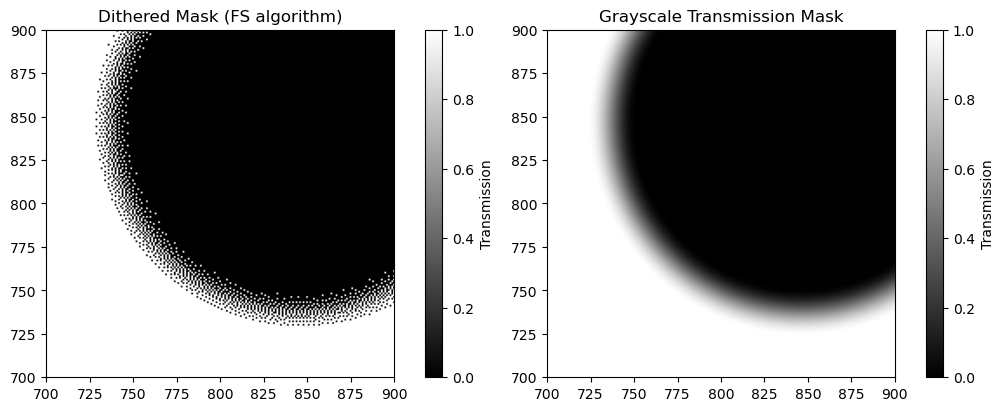

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# Binary (dithered) mask
im0 = axes[0].imshow(binary, cmap="gray", origin="lower")
axes[0].set_title("Dithered Mask (FS algorithm)")
axes[0].set_xlim(700, 900)
axes[0].set_ylim(700, 900)
fig.colorbar(im0, ax=axes[0], label="Transmission")

# Grayscale mask
im1 = axes[1].imshow(grayscale, cmap="gray", origin="lower")
axes[1].set_title("Grayscale Transmission Mask")
axes[1].set_xlim(700, 900)
axes[1].set_ylim(700, 900)
fig.colorbar(im1, ax=axes[1], label="Transmission")

plt.show()

In [66]:
# =============================================================================
# Step 1: Generate All Unique Tiles
# =============================================================================
# Generate all mask types and the picture as individual tiles

# Mask parameters (R0 in mm, delta_r in mm)
mask_params = [
    {'name': 'mask_0', 'R0': 1.5,   'delta_r': 1.00},
    {'name': 'mask_1', 'R0': 1.375, 'delta_r': 0.75},
    {'name': 'mask_2', 'R0': 1.10,  'delta_r': 0.80},
    {'name': 'mask_3', 'R0': 0.7,   'delta_r': 0.60},
    {'name': 'mask_4', 'R0': 0.414, 'delta_r': 0.672},
    {'name': 'mask_5', 'R0': 1.10,  'delta_r': 1.80},
]

# Generate mask tiles
tiles = {}
for params in tqdm(mask_params, desc="Generating mask tiles"):
    binary, _ = generate_mask(params['R0'], params['delta_r'], pixel_size_um, plate_size_inch)
    tiles[params['name']] = binary

print(f"Generated {len(tiles)} mask tiles, each {tiles['mask_0'].shape}")

Generating mask tiles: 100%|██████████| 6/6 [00:00<00:00, 11.34it/s]

Generated 6 mask tiles, each (1693, 1693)


In [67]:
# Verify tile shapes
print("Tile shapes:")
for name, tile in tiles.items():
    print(f"  {name}: {tile.shape}")

Tile shapes:
  mask_0: (1693, 1693)
  mask_1: (1693, 1693)
  mask_2: (1693, 1693)
  mask_3: (1693, 1693)
  mask_4: (1693, 1693)
  mask_5: (1693, 1693)


## 5. Layout Template and Pattern Assembly

In [68]:
# =============================================================================
# Step 2: Define Layout Template
# =============================================================================
# 5x5 grid layout specifying which tile goes in each position
# Row 0 is TOP, Row 4 is BOTTOM

layout_template = [
    ['mask_1', 'mask_1', 'mask_1', 'mask_1', 'mask_3'],   # Row 0 (top)
    ['mask_0', 'mask_0', 'mask_0', 'mask_0', 'mask_3'],   # Row 1
    ['mask_2', 'mask_2', 'mask_2', 'mask_2', 'mask_3'],   # Row 2
    ['mask_5', 'mask_5', 'mask_5', 'mask_5', 'mask_3'],   # Row 3
    ['mask_4', 'mask_4', 'mask_4', 'mask_4', 'picture'],  # Row 4 (bottom)
]

print(f"Layout: {len(layout_template)} rows x {len(layout_template[0])} cols")
print("\nLayout visualization:")
for i, row in enumerate(layout_template):
    edge = "(outer)" if i == 0 or i == len(layout_template) - 1 else "(inner)"
    print(f"  Row {i} {edge}: {row}")

Layout: 5 rows x 5 cols

Layout visualization:
  Row 0 (outer): ['mask_1', 'mask_1', 'mask_1', 'mask_1', 'mask_3']
  Row 1 (inner): ['mask_0', 'mask_0', 'mask_0', 'mask_0', 'mask_3']
  Row 2 (inner): ['mask_2', 'mask_2', 'mask_2', 'mask_2', 'mask_3']
  Row 3 (inner): ['mask_5', 'mask_5', 'mask_5', 'mask_5', 'mask_3']
  Row 4 (outer): ['mask_4', 'mask_4', 'mask_4', 'mask_4', 'picture']


## 6. Load Picture Tile

In [69]:
sanzhar_pic_path = '/Users/sanzhar123/Downloads/sanzhar-pic.jpeg'
# nelson_pic_path = '/Users/sanzhar123/Downloads/nelson.jpg'
# biggie_pic_path = '/Users/sanzhar123/Downloads/biggie.jpg'
# jessica_pic_path = '/Users/sanzhar123/Downloads/jessica-wang.jpg'

In [ ]:
# Add 300 pixel white border (within image dimensions)
border_pixels = 300
dither_sanzhar = add_border(misc_pictures(sanzhar_pic_path).transpose(), border_pixels, fill_value=1)

# Add picture to tiles dictionary
tiles['picture'] = dither_sanzhar

print(f"Picture tile shape: {dither_sanzhar.shape}")
print(f"Total tiles: {len(tiles)} ({list(tiles.keys())})")

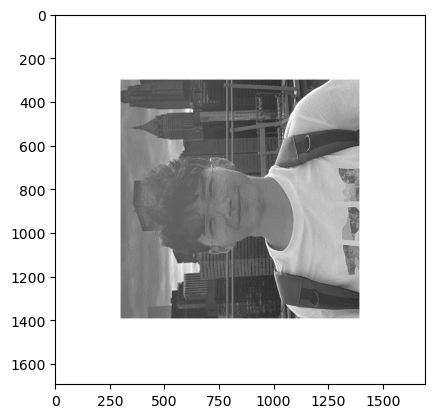

In [72]:
plt.imshow(dither_sanzhar, cmap='gray', origin='upper')
# plt.xlim(1000,1400)
# plt.ylim(1400,1000)

In [74]:
# =============================================================================
# Step 3: Assemble Pattern with Streets
# =============================================================================

# Assemble pattern using template
final_pattern = assemble_pattern_with_streets(
    tiles=tiles,
    layout=layout_template,
    full_tile_size=N,  # Inner masks: full 1" size
    street_width_px=street_width_px,
    outer_reduction_px=outer_reduction_px,
    outer_marker_px=outer_marker_px  # 0.5mm black square on outer masks
)

# Calculate outer tile size for alignment crosses
outer_tile_size = N - outer_reduction_px

# Physical sizes for alignment crosses (constant regardless of pixel size)
arm_length_um = 1000   # 1 mm
thickness_um = 160     # 0.16 mm
arm_length_px = int(arm_length_um / pixel_size_um)
thickness_px = int(thickness_um / pixel_size_um)

# Add alignment crosses in street centers
final_pattern = add_alignment_crosses_in_streets(
    final_pattern,
    layout=layout_template,
    full_tile_size=N,
    outer_tile_size=outer_tile_size,
    street_width_px=street_width_px,
    arm_length_px=arm_length_px,
    thickness_px=thickness_px
)

# Verify final size
final_size_mm = final_pattern.shape[0] * pixel_size_um / 1000
expected_size_mm = FINAL_SIZE_INCH * 25.4

print(f"\n=== Final Pattern ===")
print(f"Shape: {final_pattern.shape}")
print(f"Size: {final_size_mm:.3f} mm x {final_size_mm:.3f} mm")
print(f"Expected: {expected_size_mm:.3f} mm x {expected_size_mm:.3f} mm")
print(f"Match: {'✓' if abs(final_size_mm - expected_size_mm) < 0.5 else '✗'}")
print(f"\nAlignment cross: arm={arm_length_px}px, thickness={thickness_px}px")
print(f"Outer mask marker: {outer_marker_px}px ({OUTER_MARKER_SIZE_MM}mm)")


=== Final Pattern ===
Shape: (8413, 8413)
Size: 126.195 mm x 126.195 mm
Expected: 126.238 mm x 126.238 mm
Match: ✓

Alignment cross: arm=66px, thickness=10px
Outer mask marker: 33px (0.5mm)


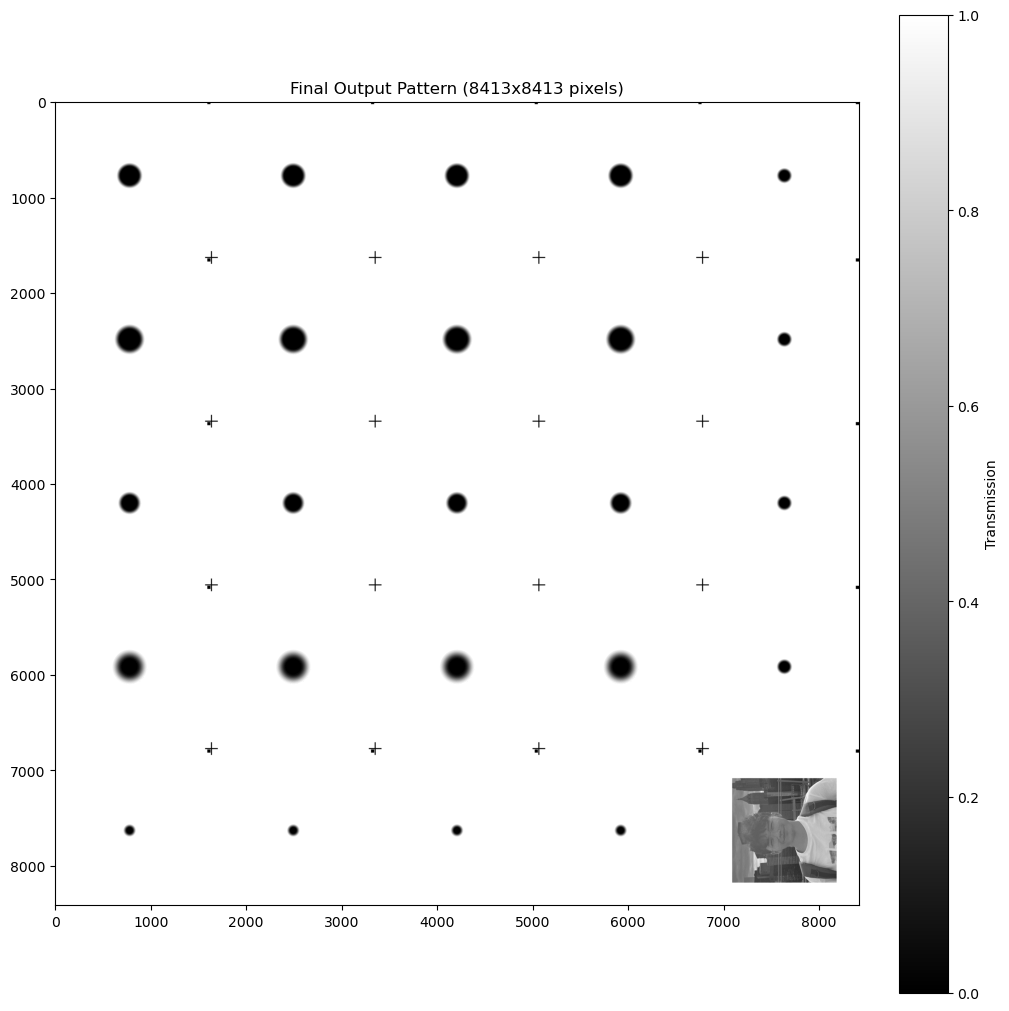


Zoomed view of street intersection (center of pattern):


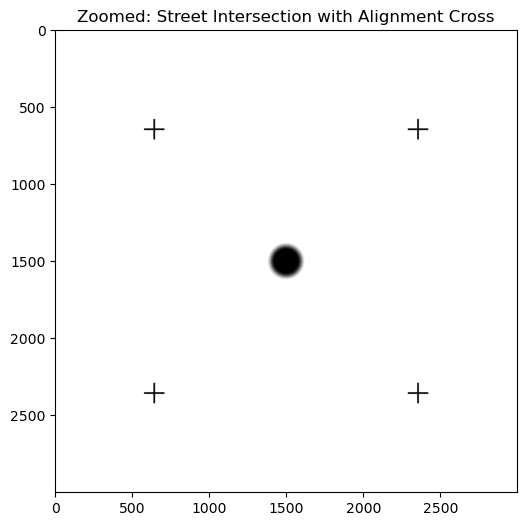

In [75]:
# Visualize final pattern
fig, ax = plt.subplots(1, figsize=(10, 10), constrained_layout=True)

im0 = ax.imshow(final_pattern, cmap="gray", origin="upper")
ax.set_title(f"Final Output Pattern ({final_pattern.shape[0]}x{final_pattern.shape[1]} pixels)")
fig.colorbar(im0, ax=ax, label="Transmission")
plt.show()

# Show zoomed view of a street intersection to verify crosses
print("\nZoomed view of street intersection (center of pattern):")
center = final_pattern.shape[0] // 2
zoom_size = 1500
fig2, ax2 = plt.subplots(figsize=(6, 6))
ax2.imshow(final_pattern[center-zoom_size:center+zoom_size, 
                          center-zoom_size:center+zoom_size], 
           cmap="gray", origin="upper")
ax2.set_title("Zoomed: Street Intersection with Alignment Cross")
plt.show()

In [51]:
# Save the final pattern as PNG
save_mask_png(final_pattern, 'final_mask.png')

PNG saved: final_mask.png, shape: (8413, 8413)


'final_mask.png'

## 7. GDS Conversion Functions

In [ ]:
# =============================================================================
# Optional: gdstk for OASIS support (5-20x better compression than GDS)
# =============================================================================
try:
    import gdstk
    GDSTK_AVAILABLE = True
except ImportError:
    GDSTK_AVAILABLE = False

# =============================================================================
# Run-Length Encoding Helper
# =============================================================================

def extract_runs(row):
    """
    Extract runs of consecutive 1s from a binary row.

    Parameters:
    -----------
    row : numpy array
        1D binary array (0s and 1s)

    Returns:
    --------
    list of tuples
        [(start_col, end_col), ...] for each run of 1s

    Example:
    --------
    >>> extract_runs(np.array([1,1,1,0,0,1,1,1,1,0,1]))
    [(0, 3), (5, 9), (10, 11)]
    """
    runs = []
    in_run = False
    start = 0

    for i in range(len(row) + 1):
        pixel = row[i] if i < len(row) else 0

        if pixel == 1 and not in_run:
            start = i
            in_run = True
        elif pixel == 0 and in_run:
            runs.append((start, i))
            in_run = False

    return runs


# =============================================================================
# OASIS Generation (requires gdstk)
# =============================================================================

def matrix_to_oasis_rle(matrix, cell_size=1.0, output_file='output.oas', chunk_size=500,
                        compression_level=6):
    """
    Memory-efficient OASIS generation using run-length encoding.

    OASIS format provides 5-20x better compression than GDS through:
    - Variable byte encoding
    - Built-in zlib compression
    - Rectangle/trapezoid detection

    Parameters:
    -----------
    matrix : numpy.ndarray or tuple (packed_data, shape)
        Binary matrix (0s and 1s) or packed binary data
    cell_size : float
        Size of each cell in microns (default: 1.0)
    output_file : str
        Path to the output OASIS file (default: 'output.oas')
    chunk_size : int
        Number of rows to process at a time (default: 500)
    compression_level : int
        Zlib compression level 0-9 (default: 6, use 9 for max compression)

    Returns:
    --------
    str
        Path to output file

    Raises:
    -------
    ImportError
        If gdstk is not installed
    """
    if not GDSTK_AVAILABLE:
        raise ImportError("gdstk required for OASIS. Install with: pip install gdstk")

    # Handle packed input
    if isinstance(matrix, tuple) and len(matrix) == 2:
        packed, shape = matrix
        matrix = unpack_binary(packed, shape)

    height, width = matrix.shape
    total_rects = 0
    total_pixels = 0

    # Create library and cell
    lib = gdstk.Library()
    cell = lib.new_cell('PATTERN')

    for row_idx in tqdm(range(height), desc="Processing rows (OASIS+RLE)"):
        row = matrix[row_idx, :]
        y = (height - row_idx - 1) * cell_size

        # Count pixels for stats
        total_pixels += np.sum(row)

        # Extract runs and create rectangles
        runs = extract_runs(row)
        for start_col, end_col in runs:
            x1 = start_col * cell_size
            x2 = end_col * cell_size
            rect = gdstk.rectangle((x1, y), (x2, y + cell_size), layer=1)
            cell.add(rect)
            total_rects += 1

    # Write OASIS with compression
    lib.write_oas(
        output_file,
        compression_level=compression_level,
        detect_rectangles=True,
        detect_trapezoids=True,
    )

    compression = (1 - total_rects / total_pixels) * 100 if total_pixels > 0 else 0
    print(f"RLE: {total_pixels:,} pixels -> {total_rects:,} rectangles ({compression:.1f}% reduction)")
    print(f"OASIS written: {output_file}, shape: {matrix.shape}")

    return output_file


# =============================================================================
# GDS Generation Functions
# =============================================================================

def matrix_to_gds_rle(matrix, cell_size=1.0, output_file='output.gds', chunk_size=500):
    """
    Memory-efficient GDS generation using run-length encoding.

    Creates horizontal strips instead of individual pixel rectangles,
    reducing file size by 30-50% for dithered patterns.

    Parameters:
    -----------
    matrix : numpy.ndarray or tuple (packed_data, shape)
        Binary matrix (0s and 1s) or packed binary data
    cell_size : float
        Size of each cell in microns (default: 1.0)
    output_file : str
        Path to the output GDS file
    chunk_size : int
        Number of rows to process at a time (default: 500)

    Returns:
    --------
    list
        List of output file paths (one per chunk)
    """
    # Handle packed input
    if isinstance(matrix, tuple) and len(matrix) == 2:
        packed, shape = matrix
        matrix = unpack_binary(packed, shape)

    height, width = matrix.shape
    num_chunks = (height + chunk_size - 1) // chunk_size
    base_name = output_file.rsplit('.gds', 1)[0]
    output_files = []
    total_rects = 0
    total_pixels = 0

    for chunk_idx in tqdm(range(num_chunks), desc="Processing chunks (RLE)"):
        row_start = chunk_idx * chunk_size
        row_end = min(row_start + chunk_size, height)

        gdspy.current_library = gdspy.GdsLibrary()
        lib = gdspy.GdsLibrary()
        cell = lib.new_cell(f'CHUNK_{chunk_idx}')

        for row_idx in range(row_start, row_end):
            row = matrix[row_idx, :]
            y = (height - row_idx - 1) * cell_size

            # Count pixels for stats
            total_pixels += np.sum(row)

            # Extract runs and create rectangles
            runs = extract_runs(row)
            for start_col, end_col in runs:
                x1 = start_col * cell_size
                x2 = end_col * cell_size
                rect = gdspy.Rectangle((x1, y), (x2, y + cell_size), layer=1)
                cell.add(rect)
                total_rects += 1

        # Write chunk file
        if num_chunks == 1:
            chunk_file = output_file
        else:
            chunk_file = f"{base_name}_chunk{chunk_idx:03d}.gds"

        lib.write_gds(chunk_file)
        output_files.append(chunk_file)

        del lib, cell

    compression = (1 - total_rects / total_pixels) * 100 if total_pixels > 0 else 0
    print(f"RLE: {total_pixels:,} pixels -> {total_rects:,} rectangles ({compression:.1f}% reduction)")
    print(f"GDS written: {len(output_files)} file(s), shape: {matrix.shape}")

    if num_chunks > 1:
        print(f"Files: {output_files[0]} ... {output_files[-1]}")

    return output_files


def matrix_to_gds_chunked(matrix, cell_size=1.0, output_file='output.gds', chunk_size=500):
    """
    Memory-efficient GDS generation - writes separate files per chunk.
    Uses 1x1 rectangles (no RLE compression).

    For very large patterns (e.g., 1.6 micron pixel size), this function
    writes each chunk to a separate GDS file to avoid memory exhaustion.

    Parameters:
    -----------
    matrix : numpy.ndarray or tuple (packed_data, shape)
        Binary matrix (0s and 1s) or packed binary data from pack_binary()
    cell_size : float
        Size of each cell in microns (default: 1.0)
    output_file : str
        Path to the output GDS file
    chunk_size : int
        Number of rows to process at a time (default: 500)

    Returns:
    --------
    list
        List of output file paths (one per chunk)
    """
    # Handle packed input
    if isinstance(matrix, tuple) and len(matrix) == 2:
        packed, shape = matrix
        matrix = unpack_binary(packed, shape)

    height, width = matrix.shape
    num_chunks = (height + chunk_size - 1) // chunk_size

    # Determine if we need multi-file output
    base_name = output_file.rsplit('.gds', 1)[0]
    output_files = []
    total_pixels = 0

    for chunk_idx in tqdm(range(num_chunks), desc="Processing chunks"):
        row_start = chunk_idx * chunk_size
        row_end = min(row_start + chunk_size, height)

        # Fresh library for each chunk to free memory
        gdspy.current_library = gdspy.GdsLibrary()
        lib = gdspy.GdsLibrary()
        cell = lib.new_cell(f'CHUNK_{chunk_idx}')

        # Extract chunk
        chunk = matrix[row_start:row_end, :]
        sp = sparse.coo_matrix(chunk)
        rows = sp.row + row_start
        cols = sp.col

        # Create rectangles
        for i, j in zip(rows, cols):
            x1 = j * cell_size
            y1 = (height - i - 1) * cell_size
            rect = gdspy.Rectangle((x1, y1), (x1 + cell_size, y1 + cell_size), layer=1)
            cell.add(rect)

        total_pixels += len(rows)

        # Write chunk to separate file
        if num_chunks == 1:
            chunk_file = output_file
        else:
            chunk_file = f"{base_name}_chunk{chunk_idx:03d}.gds"

        lib.write_gds(chunk_file)
        output_files.append(chunk_file)

        # Clear memory
        del chunk, sp, rows, cols, lib, cell

    print(f"GDS written: {len(output_files)} file(s), shape: {matrix.shape}, pixels: {total_pixels}")
    if num_chunks > 1:
        print(f"Files: {output_files[0]} ... {output_files[-1]}")
        print("Merge with KLayout or gdspy externally if needed.")

    return output_files


def matrix_to_gds_fast(matrix, cell_size=1.0, output_file='output.gds'):
    """
    Optimized GDS generation using sparse coordinates.
    
    Note: For very large matrices, use matrix_to_gds_chunked() instead.
    
    Parameters:
    -----------
    matrix : numpy.ndarray or scipy.sparse matrix
        Binary matrix (0s and 1s)
    cell_size : float
        Size of each cell in microns (default: 1.0)
    output_file : str
        Path to the output GDS file
    
    Returns:
    --------
    str
        Path to the output GDS file
    """
    gdspy.current_library = gdspy.GdsLibrary()
    lib = gdspy.GdsLibrary()
    cell = lib.new_cell('PATTERN')

    # Convert to sparse COO format for efficient coordinate access
    if not sparse.issparse(matrix):
        sp = sparse.coo_matrix(matrix)
    else:
        sp = matrix.tocoo()

    height = matrix.shape[0]
    rows, cols = sp.row, sp.col

    # Create all rectangles using sparse coordinates
    for i, j in tqdm(zip(rows, cols), total=len(rows), desc="Writing GDS"):
        x1 = j * cell_size
        y1 = (height - i - 1) * cell_size
        rect = gdspy.Rectangle((x1, y1), (x1 + cell_size, y1 + cell_size), layer=1)
        cell.add(rect)

    lib.write_gds(output_file)
    print(f"GDS written: {output_file}, shape: {matrix.shape}, nnz: {len(rows)}")
    return output_file


def matrix_to_gds(matrix, cell_size=1.0, output_file='output.gds',
                  use_chunked=True, chunk_size=500, use_rle=True,
                  output_format='gds', compression_level=6):
    """
    Convert binary matrix to GDS or OASIS file(s).
    
    Parameters:
    -----------
    matrix : numpy.ndarray or tuple (packed_data, shape)
        Binary matrix (0s and 1s) or packed binary data
    cell_size : float
        Size of each cell in microns (default: 1.0)
    output_file : str
        Path to the output file
    use_chunked : bool
        If True, use memory-efficient chunked processing (default: True)
    chunk_size : int
        Number of rows per chunk when using chunked mode (default: 500)
    use_rle : bool
        If True, use run-length encoding for compression (default: True)
    output_format : str
        'gds' for GDSII format, 'oasis' for OASIS format (default: 'gds')
    compression_level : int
        OASIS compression level 0-9 (default: 6)
    
    Returns:
    --------
    str or list
        Single file path, or list of chunk file paths for large patterns
    """
    if output_format == 'oasis':
        # Ensure .oas extension
        if not output_file.endswith('.oas'):
            output_file = output_file.rsplit('.', 1)[0] + '.oas'
        return matrix_to_oasis_rle(matrix, cell_size, output_file, chunk_size, compression_level)
    elif use_rle:
        return matrix_to_gds_rle(matrix, cell_size, output_file, chunk_size)
    elif use_chunked:
        return matrix_to_gds_chunked(matrix, cell_size, output_file, chunk_size)
    else:
        return matrix_to_gds_fast(matrix, cell_size, output_file)


def merge_gds_chunks(chunk_files, output_file='merged.gds', flatten=False):
    """
    Merge multiple GDS chunk files into a single GDS file.

    Uses CellReferences for memory efficiency - geometry stays in
    sub-cells rather than being copied to a flat structure.

    Parameters:
    -----------
    chunk_files : list
        List of GDS file paths to merge
    output_file : str
        Path for the merged output file
    flatten : bool
        If True, flatten all geometry into one cell (uses more memory).
        If False, use CellReferences (memory-efficient, recommended).

    Returns:
    --------
    str
        Path to the merged output file

    Note:
    -----
    For very large patterns, this merge may still require significant memory.
    If it crashes, use KLayout: File > Import each chunk, then export combined.
    """
    merged_lib = gdspy.GdsLibrary()

    # Read all chunk files
    for chunk_file in tqdm(chunk_files, desc="Reading chunks"):
        merged_lib.read_gds(chunk_file)

    # Create top-level cell with references to all chunks
    top_cell = merged_lib.new_cell('PATTERN')

    for cell_name in list(merged_lib.cells.keys()):
        if cell_name != 'PATTERN' and cell_name.startswith('CHUNK_'):
            if flatten:
                # Copy all polygons (uses more memory)
                polygons = merged_lib.cells[cell_name].get_polygons(by_spec=True)
                for (layer, datatype), polys in polygons.items():
                    for poly in polys:
                        top_cell.add(gdspy.Polygon(poly, layer=layer, datatype=datatype))
            else:
                # Use CellReference (memory-efficient)
                ref = gdspy.CellReference(merged_lib.cells[cell_name])
                top_cell.add(ref)

    merged_lib.write_gds(output_file)
    print(f"Merged {len(chunk_files)} chunks -> {output_file}")
    return output_file


def gds_to_matrix(input_file, cell_size=1.0, expected_shape=None, layer=1):
    """
    Convert a GDS file back to a binary matrix.
    
    Handles both single-pixel rectangles and RLE strips.
    
    Parameters:
    -----------
    input_file : str
        Path to the GDS file
    cell_size : float
        Size of each cell (must match the cell_size used when creating the GDS)
    expected_shape : tuple or None
        Expected (height, width) of the output matrix. If None, infer from bounding box.
    layer : int
        The layer number to extract (default: 1)
    
    Returns:
    --------
    numpy.ndarray
        Binary matrix with 1s where rectangles exist, 0s elsewhere
    """
    lib = gdspy.GdsLibrary(infile=input_file)
    cell = lib.top_level()[0]
    polygons = cell.get_polygons(by_spec=True)
    
    # Find polygons on the target layer
    target_key = None
    for key in polygons.keys():
        if key[0] == layer:  # key is (layer, datatype)
            target_key = key
            break
    
    if target_key is None:
        raise ValueError(f"No polygons found on layer {layer}")
    
    poly_list = polygons[target_key]
    
    # Use expected shape if provided, otherwise infer from bounding box
    if expected_shape:
        height, width = expected_shape
    else:
        all_points = np.vstack(poly_list)
        x_max, y_max = all_points.max(axis=0)
        width = int(round(x_max / cell_size))
        height = int(round(y_max / cell_size))
    
    # Initialize empty matrix
    matrix = np.zeros((height, width), dtype=np.uint8)
    
    # Fill in the matrix based on rectangle positions
    # Handles both 1x1 rectangles and RLE strips
    for poly in tqdm(poly_list, desc="Reading GDS"):
        x_min = poly[:, 0].min()
        x_max = poly[:, 0].max()
        y_min = poly[:, 1].min()
        
        # Calculate grid positions
        col_start = int(round(x_min / cell_size))
        col_end = int(round(x_max / cell_size))
        row = height - 1 - int(round(y_min / cell_size))
        
        # Fill all pixels in the strip
        if 0 <= row < height:
            col_start = max(0, col_start)
            col_end = min(width, col_end)
            matrix[row, col_start:col_end] = 1
    
    print(f"GDS read: {input_file}, shape: {matrix.shape}")
    return matrix


def oasis_to_matrix(input_file, cell_size=1.0, expected_shape=None, layer=1, datatype=0):
    """
    Convert an OASIS file back to a binary matrix.
    Requires gdstk.

    Parameters:
    -----------
    input_file : str
        Path to the OASIS file
    cell_size : float
        Size of each cell (must match the cell_size used when creating the OASIS)
    expected_shape : tuple or None
        Expected (height, width) of the output matrix
    layer : int
        The layer number to extract (default: 1)
    datatype : int
        The datatype to extract (default: 0)

    Returns:
    --------
    numpy.ndarray
        Binary matrix with 1s where rectangles exist, 0s elsewhere
    """
    if not GDSTK_AVAILABLE:
        raise ImportError("gdstk required to read OASIS files. Install: pip install gdstk")

    lib = gdstk.read_oas(input_file)
    cell = lib.top_level()[0]
    polygons = cell.get_polygons(layer=layer, datatype=datatype)

    # Determine dimensions
    if expected_shape:
        height, width = expected_shape
    else:
        all_points = np.vstack([p.points for p in polygons])
        x_max, y_max = all_points.max(axis=0)
        width = int(round(x_max / cell_size))
        height = int(round(y_max / cell_size))

    matrix = np.zeros((height, width), dtype=np.uint8)

    for poly in tqdm(polygons, desc="Reading OASIS"):
        points = poly.points
        x_min, y_min = points.min(axis=0)
        x_max, _ = points.max(axis=0)

        col_start = int(round(x_min / cell_size))
        col_end = int(round(x_max / cell_size))
        row = height - 1 - int(round(y_min / cell_size))

        if 0 <= row < height:
            matrix[row, max(0, col_start):min(width, col_end)] = 1

    print(f"OASIS read: {input_file}, shape: {matrix.shape}")
    return matrix


def verify_gds_roundtrip(matrix, cell_size=1.0, gds_file='test_roundtrip.gds',
                         chunk_size=None):
    """
    Verify matrix -> GDS -> matrix roundtrip.
    Handles chunked output by merging before reading back.

    Parameters:
    -----------
    matrix : numpy.ndarray
        Input binary matrix to test
    cell_size : float
        Size of each cell in microns
    gds_file : str
        GDS file path for testing
    chunk_size : int or None
        Chunk size for writing. If None, uses matrix height+1 to avoid chunking.

    Returns:
    --------
    tuple: (success, matrix_out, diff_count)
    """
    # Avoid chunking for verification by using large chunk_size
    if chunk_size is None:
        chunk_size = max(500, matrix.shape[0] + 1)

    # Write to GDS
    result = matrix_to_gds(matrix, cell_size=cell_size, output_file=gds_file,
                           use_rle=True, chunk_size=chunk_size)

    # Handle chunked output - merge if needed
    if isinstance(result, list) and len(result) > 1:
        merged_file = gds_file.replace('.gds', '_merged.gds')
        merge_gds_chunks(result, output_file=merged_file)
        read_file = merged_file
    else:
        read_file = result[0] if isinstance(result, list) else result

    # Read back and compare
    matrix_out = gds_to_matrix(read_file, cell_size=cell_size,
                                expected_shape=matrix.shape)

    diff = np.sum(matrix != matrix_out)
    success = (diff == 0)

    print(f"=== GDS Roundtrip Verification ===")
    print(f"Input shape:  {matrix.shape}")
    print(f"Output shape: {matrix_out.shape}")
    print(f"Differences:  {diff} pixels")
    print(f"Verdict: {'PASS' if success else 'FAIL'}")

    return success, matrix_out, diff


def verify_oasis_roundtrip(matrix, cell_size=1.0, oas_file='test_roundtrip.oas',
                           compression_level=6):
    """
    Verify matrix -> OASIS -> matrix roundtrip.

    Parameters:
    -----------
    matrix : numpy.ndarray
        Input binary matrix to test
    cell_size : float
        Size of each cell in microns
    oas_file : str
        OASIS file path for testing
    compression_level : int
        Zlib compression level 0-9

    Returns:
    --------
    tuple: (success, matrix_out, diff_count) or (None, None, None) if gdstk unavailable
    """
    if not GDSTK_AVAILABLE:
        print("OASIS verification requires gdstk. Install: pip install gdstk")
        return None, None, None

    # Write to OASIS
    matrix_to_oasis_rle(matrix, cell_size=cell_size, output_file=oas_file,
                        compression_level=compression_level)

    # Read back
    matrix_out = oasis_to_matrix(oas_file, cell_size=cell_size,
                                  expected_shape=matrix.shape)

    diff = np.sum(matrix != matrix_out)
    success = (diff == 0)

    print(f"=== OASIS Roundtrip Verification ===")
    print(f"Input shape:  {matrix.shape}")
    print(f"Output shape: {matrix_out.shape}")
    print(f"Differences:  {diff} pixels")
    print(f"Verdict: {'PASS' if success else 'FAIL'}")

    return success, matrix_out, diff

## 8. Generate Final GDS File

In [ ]:
# Generate pattern file - choose format based on availability
if GDSTK_AVAILABLE:
    print("gdstk available - using OASIS format for best compression")
    output_file = matrix_to_gds(final_pattern, cell_size=pixel_size_um,
                                 output_file='final_pattern.oas',
                                 output_format='oasis')
else:
    print("gdstk not available - using GDS with RLE compression")
    print("For better compression, install gdstk: pip install gdstk")
    gds_files = matrix_to_gds(final_pattern, cell_size=pixel_size_um,
                               output_file='final_pattern.gds')

    if isinstance(gds_files, list) and len(gds_files) > 1:
        print(f"\nPattern split into {len(gds_files)} GDS files due to size.")
        print("Attempting to merge chunks...")
        try:
            merged_file = merge_gds_chunks(gds_files, output_file='final_pattern.gds')
            print(f"Successfully merged to: {merged_file}")
        except MemoryError:
            print("Merge failed (out of memory). Use KLayout to merge manually:")
            print("  File > Import > GDS (import each chunk), then File > Export")